In [13]:
try:
    import numpy as np
except:
    np.ndarray='np.ndarray'
    print("Numpy was not imported")
    pass
try:
    import pandas
except:
    print("Pandas was not imported")
    pass
try:
    from scipy.stats.mstats import gmean
except:
    print("The function gmean from the package scipy.stats.mstats did not import correctly ")
try:
    from statsmodels.robust.scale import mad
except:
    print("The function mad from the package statsmodels.robust.scale did not import correctly ")

In [14]:
def independent_variable_model_collapse(model,independent_column_name="Frequency", **options):
    """Returns a model with a single set of independent variables. Default is to average values together
    but geometric mean, std, variance, rss, mad and median are options.
    Geometric means of odd number of negative values fails"""
    if type(model) in [pandas.DataFrame]:
        model_1 = DataFrame_to_AsciiDataTable(model)
    defaults = {"method": "mean"}
    # load other options from model
    for option, value in model.options.iteritems():
        if not re.search('begin_line|end_line', option):
            defaults[option] = value
    for element in model.elements:
        if model.__dict__[element]:
            if re.search("meta", element, re.IGNORECASE):
                defaults["metadata"] = model.metadata.copy()
            else:
                defaults[element] = model.__dict__[element][:]
    # We need to preserve the frequency column some how
    collapse_options = {}
    for key, value in defaults.iteritems():
        collapse_options[key] = value
    for key, value in options.iteritems():
        collapse_options[key] = value
    unique_independent_variable_list = sorted(list(set(model[independent_column_name])))
    independent_variable_selector = model.column_names.index(independent_column_name)
    out_data = []
    for index, independent_variable in enumerate(unique_independent_variable_list):
        data_row = filter(lambda x: x[independent_variable_selector] == independent_variable, model.data[:])
        if re.search('mean|av', collapse_options["method"], re.IGNORECASE):
            new_row = np.mean(np.array(data_row), axis=0).tolist()
        elif re.search('median', collapse_options["method"], re.IGNORECASE):
            new_row = np.median(np.array(data_row), axis=0).tolist()
        elif re.search('geometric', collapse_options["method"], re.IGNORECASE):
            new_row = gmean(np.array(data_row), axis=0).tolist()
        elif re.search('st', collapse_options["method"], re.IGNORECASE):
            new_row = np.std(np.array(data_row), axis=0).tolist()
        elif re.search('var', collapse_options["method"], re.IGNORECASE):
            new_row = np.var(np.array(data_row), axis=0, dtype=np.float64).tolist()
        elif re.search('rms', collapse_options["method"], re.IGNORECASE):
            new_row = np.sqrt(np.mean(np.square(np.array(data_row)), axis=0, dtype=np.float64)).tolist()
        elif re.search('rss', collapse_options["method"], re.IGNORECASE):
            new_row = np.sqrt(np.sum(np.square(np.array(data_row)), axis=0, dtype=np.float64)).tolist()
        elif re.search('mad', collapse_options["method"], re.IGNORECASE):
            new_row = mad(np.array(data_row), axis=0).tolist()
        new_row[independent_variable_selector]=independent_variable
        out_data.append(new_row)

    collapse_options["data"] = out_data

    if collapse_options["specific_descriptor"]:
        collapse_options["specific_descriptor"] = collapse_options["method"] + "_" + \
                                                  collapse_options["specific_descriptor"]
    resulting_model = AsciiDataTable(None, **collapse_options)
    return resulting_model


In [2]:
def independent_variable_model_difference(model_1, model_2, independent_column_name="Frequency",**options):
    """Takes the difference of two models that both have frequency and a similar set of columns. Returns an object that is
    a list of [[independent_variable,column_1,..column_n],...] where columns are the same in the models. If  a particular subset of
    columns is desired use columns=[independent_variable,column_name_1,..column_name_n] models 
    can be any subclass of AsciiDataTable, SNP, or
    pandas.DataFrame, if a column is a non-numeric type it drops it. """
    # Set up defaults and pass options
    defaults = {"columns": "all", "interpolate": False, "average": True}
    difference_options = {}
    for key, value in defaults.iteritems():
        difference_options[key] = value
    for key, value in options.iteritems():
        difference_options[key] = value

    # first check type, if it is a panadas data frame a little conversion is needed, else is for all other models
    if type(model_1) in [pandas.DataFrame]:
        model_1 = DataFrame_to_AsciiDataTable(model_1)
    if type(model_2) in [pandas.DataFrame]:
        model_2 = DataFrame_to_AsciiDataTable(model_2)
    # now start with a set of frequencies (unique values from both)
    independent_variable_set_1 = set(model_1[independent_column_name])
    independent_variable_set_2 = set(model_2[independent_column_name])
    model_2_independent_variable_selector = model_2.column_names.index(independent_column_name)
    column_names_set_1 = set(model_1.column_names)
    column_names_set_2 = set(model_2.column_names)

    # All points must be in the intersection to be used
    independent_variable_intersection = list(independent_variable_set_1.intersection(independent_variable_set_2))
    column_names_intersection = list(column_names_set_1.intersection(column_names_set_2))

    if not independent_variable_intersection:
        print("The models do not have any {0} points in common".format(independent_column_name))
        return None
    new_column_names = [independent_column_name]
    column_types=['float']
    for column_index, column in enumerate(model_1.column_names):
        if column in column_names_intersection and column not in [independent_column_name]:
            new_column_names.append(column)
            column_types.append(model_1.options["column_types"][column_index])

    difference_data = []
    for row_index, independent_variable in enumerate(model_1[independent_column_name]):
        new_row = [independent_variable]
        if independent_variable in independent_variable_intersection:
            model_2_independent_variable_row = filter(lambda x: x[model_2_independent_variable_selector] == independent_variable,
                                                      model_2.data)[0]
            
            for column_index, column in enumerate(model_1.column_names):
                if column in column_names_intersection and column not in [independent_column_name]:
                    model_2_column_selector = model_2.column_names.index(column)
                    if re.search('int|float',
                                 model_1.options["column_types"][column_index],
                                 re.IGNORECASE) and re.search('int|float',
                                                              model_2.options["column_types"][model_2_column_selector],
                                                              re.IGNORECASE):

                        new_row.append(
                            model_1.data[row_index][column_index] - model_2_independent_variable_row[model_2_column_selector])

                        # Print("New Column Names are {0}".format(new_column_names))
                    elif difference_options["columns"] in ["all"]:
                        new_row.append(model_1.data[row_index][column_index])
            difference_data.append(new_row)
    difference_options["column_names"] = new_column_names
    # print("New Column Names are {0}".format(new_column_names))
    difference_options["data"] = difference_data
    difference_options["column_types"]=column_types
    #print column_types
    result = AsciiDataTable(None, **difference_options)
    return result

In [3]:
from pyMez import *

Importing pyMez, this should take roughly 30 seconds
Importing Code.DataHandlers.GeneralModels
It took 4.307 s to import Code.DataHandlers.GeneralModels
Importing Code.DataHandlers.HTMLModels
It took 0.786 s to import Code.DataHandlers.HTMLModels
Importing Code.DataHandlers.NISTModels
It took 14.59 s to import Code.DataHandlers.NISTModels
Importing Code.DataHandlers.TouchstoneModels
It took 0.015 s to import Code.DataHandlers.TouchstoneModels
Importing Code.DataHandlers.XMLModels
It took 0.467 s to import Code.DataHandlers.XMLModels
Importing Code.DataHandlers.ZipModels
It took 0.11 s to import Code.DataHandlers.ZipModels
Importing Code.InstrumentControl.Experiments
It took 1.946 s to import Code.InstrumentControl.Experiments
Importing Code.InstrumentControl.Instruments
It took 0.021 s to import Code.InstrumentControl.Instruments
Importing Code.Utils.Names
It took 0.016 s to import Code.Utils.Names
It took 22.259 s to import all of the active modules


In [4]:
from pyMez.Code.DataHandlers.Translations import *

In [5]:
s2p=SNP(r"C:\Share\WR15_OML_MUF_20180313\TRL_1\DUTs\Line_4909_WR15_20180313_001.s2p")

In [6]:
data_table=Snp_to_AsciiDataTable(s2p)

In [15]:
directory=r"C:\Share\WR15_OML_20180309\Atten3DB\s2p"
file_names=os.listdir(directory)
file_names=map(lambda x:os.path.join(directory,x),file_names)

In [16]:
first_file=Snp_to_AsciiDataTable(SNP(file_names[0]))
joined_table=first_file.copy()
for snp_name in file_names[1:]:
    joined_table+Snp_to_AsciiDataTable(SNP(snp_name))


In [17]:
mean_table=independent_variable_model_collapse(joined_table)
std_table=independent_variable_model_collapse(joined_table,method="std")
median_table=independent_variable_model_collapse(joined_table,method="median")
mad_table=independent_variable_model_collapse(joined_table,method="mad")

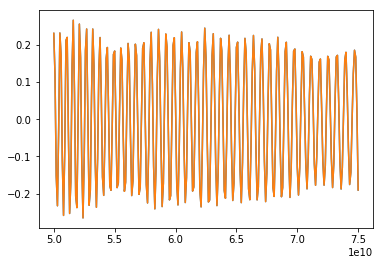

In [20]:
plt.plot(mean_table["Frequency"],mean_table["reS21"])
plt.plot(median_table["Frequency"],median_table["reS21"])
plt.show()

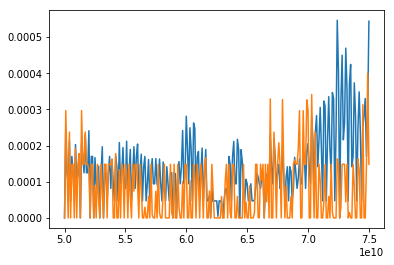

In [21]:
plt.plot(std_table["Frequency"],std_table["reS21"])
plt.plot(mad_table["Frequency"],mad_table["reS21"])
plt.show()

In [22]:
diff=independent_variable_model_difference(mean_table,median_table)

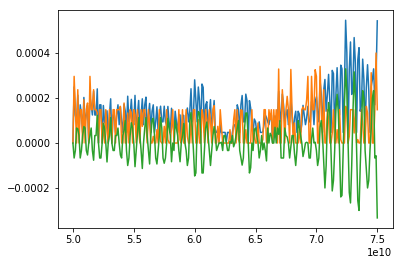

In [23]:
plt.plot(std_table["Frequency"],std_table["reS21"])
plt.plot(mad_table["Frequency"],mad_table["reS21"])
plt.plot(diff["Frequency"],diff["reS21"])
plt.show()

In [24]:
directory=r"C:\Share\WR15_OML_20180309\Atten3DB\s2p"
file_names=os.listdir(directory)
file_names=map(lambda x:os.path.join(directory,x),file_names)


In [27]:
s2p_list=map(lambda x:SNP(x),file_names)
data_table_list=map(lambda x:Snp_to_AsciiDataTable(x),s2p_list)

In [28]:
joined_file=sum(data_table_list)

TypeError: unsupported operand type(s) for +: 'int' and 'AsciiDataTable'

In [29]:
def join_table_list(table_list):
    first=table_list[0]
    joined_table=first.copy()
    for table in table_list[1:]:
        joined_table+table
    return joined_table
    

In [30]:
joined_file=join_table_list(data_table_list)

In [31]:
print(joined_file)

Frequency,reS11,imS11,reS21,imS21,reS12,imS12,reS22,imS22
50000000000.0  0.006799  -0.005384  0.2312  0.04646  0.1823  0.1266  -0.009555  0.02447
50100000000.0  0.0252  -0.02552  0.1178  -0.2049  0.1924  -0.09844  0.01013  0.03473
50200000000.0  -0.02759  -0.008958  -0.1525  -0.1892  -0.009237  -0.2124  0.04058  -0.005587
50300000000.0  -0.01801  -0.01126  -0.2324  0.06598  -0.1959  -0.07143  0.01299  -0.02308
50400000000.0  -0.007804  0.04144  -0.02689  0.2451  -0.1465  0.1421  -0.01239  -0.03321
50500000000.0  0.009756  -0.001801  0.2323  0.1006  0.05453  0.1942  -0.03082  0.007118
50600000000.0  0.02966  0.002337  0.1705  -0.1869  0.1952  0.04066  -0.003314  0.0171
50700000000.0  -0.01961  -0.02334  -0.1118  -0.2333  0.1173  -0.158  0.01239  0.01497
50800000000.0  -0.002164  -0.002629  -0.2584  0.01304  -0.09625  -0.1695  0.01992  -0.02076
50900000000.0  -0.0208  0.02405  -0.08278  0.2471  -0.1924  0.01111  -0.01878  -0.01537
51000000000.0  0.01927  0.006169  0.2124  0.1569  -0.0814